In [101]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import datetime
import pandas as pd
import itertools
import sys
import os
import math
sys.path.append('../..')
import scipy.optimize as opt
from joblib import Parallel, delayed
from functools import partial
from hyperopt import hp, tpe, fmin, Trials
from models.optim.seir_dis import SEIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
def get_impact(choice):
    return(1+2*choice)

# np.array([start days]), np.array([duration]), np.array([choice], number_of_days_simulated)
def calculate_opt(intervention_day, intervention_duration, intervention_choice, days):
    R0 = 3 
    T_inf = 30
    T_trans = T_inf/R0
    T_inc = 5
    T_recov_mild = (50 - T_inf)
    T_hosp = 10
    T_recov_severe = (50 - T_inf)
    T_death = 50

    P_severe = 0.3
    P_fatal = 0.04
    P_mild = 1 - P_severe - P_fatal

    N = 1e6
    I0 = 100.0

    assert(len(intervention_day) == len(intervention_duration))
    assert(len(intervention_duration) == len(intervention_choice))
    
    k = len(intervention_day)
    int_vec = np.ones(days)
    for intvn in range(k):
        for i in range(intervention_day[intvn],min(intervention_day[intvn]+intervention_duration[intvn],days)):
            int_vec[i] = get_impact(intervention_choice[intvn])
    
    params = [T_trans, T_inc, T_inf, T_recov_mild, T_hosp, T_recov_severe, T_death, 
              P_mild, P_severe, P_fatal, N, int_vec]

    # S, E, I, R_mild, R_severe, R_severe_home, R_fatal, C, D
    state_init_values = [(N - I0)/N, 0, I0/N, 0, 0, 0, 0, 0, 0]
    
    solver = SEIR(params, state_init_values)
    states_int_array = solver.solve_ode(time_step=1, total_no_of_days=days)
    
    
    S_coeficeint=0
    E_coeficeint=0
    I_coeficeint=0.7
    R_mild_coeficeint=0.7
    R_severe_coeficeint=0.9
    R_severe_hosp_coeficeint=0.9
    R_R_fatal_coeficeint=0.9
    C_coeficeint=0
    D_coeficeint=1
    
    
    coeficeint=[S_coeficeint,E_coeficeint,I_coeficeint,R_mild_coeficeint,R_severe_coeficeint,R_severe_hosp_coeficeint,\
                R_R_fatal_coeficeint,C_coeficeint,D_coeficeint]
    
    grad1 = np.dot(coeficeint,np.sum(states_int_array, axis=1))
    return(grad1, states_int_array)

In [144]:
grad1, states_base = calculate_opt(intervention_day=np.array([100]), intervention_duration=np.array([50]), intervention_choice=np.array([0]), days=300)
print(grad1)

35.09226133555329


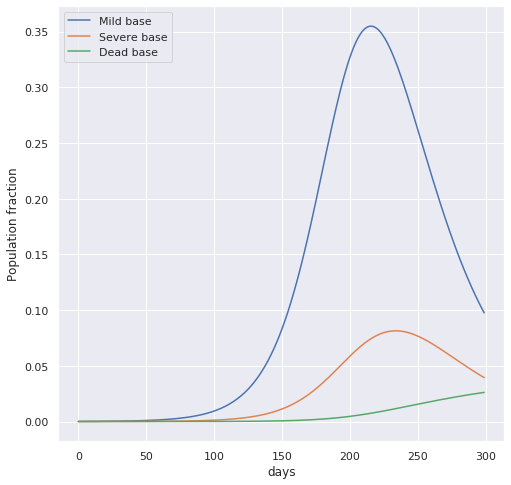

In [145]:
ind = np.arange(300)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8,8))
plt.plot(ind, states_base[2]+states_base[3], label='Mild base')
plt.plot(ind, states_base[4]+states_base[5]+states_base[6], label='Severe base')
plt.plot(ind, states_base[8], label='Dead base')
plt.ylabel('Population fraction')
plt.xlabel('days')
plt.legend()
plt.show()

In [148]:
def check(start_array, duration_array, choice_array, total_resource, days):
    for i in range(1,len(start_array)):
        if(start_array[i] <= start_array[i-1] + duration_array[i-1]):
            return(0)
    if(start_array[-1]+duration_array[-1]>=days):
        return(0)
    resource_spent = np.dot(duration_array, choice_array)
    if(resource_spent != total_resource):
        return(0)
    else:
        return(1)
    
def calculate_opt_val(intervention_day, intervention_duration, intervention_choice, days):
    R0 = 3 
    T_inf = 30
    T_trans = T_inf/R0
    T_inc = 5
    T_recov_mild = (50 - T_inf)
    T_hosp = 10
    T_recov_severe = (50 - T_inf)
    T_death = 50

    P_severe = 0.3
    P_fatal = 0.04
    P_mild = 1 - P_severe - P_fatal

    N = 1e6
    I0 = 100.0

    assert(len(intervention_day) == len(intervention_duration))
    assert(len(intervention_duration) == len(intervention_choice))
    
    k = len(intervention_day)
    int_vec = np.ones(days)
    for intvn in range(k):
        for i in range(intervention_day[intvn],min(intervention_day[intvn]+intervention_duration[intvn],days)):
            int_vec[i] = get_impact(intervention_choice[intvn])
    
    params = [T_trans, T_inc, T_inf, T_recov_mild, T_hosp, T_recov_severe, T_death, 
              P_mild, P_severe, P_fatal, N, int_vec]

    # S, E, I, R_mild, R_severe, R_severe_home, R_fatal, C, D
    state_init_values = [(N - I0)/N, 0, I0/N, 0, 0, 0, 0, 0, 0]
    
    solver = SEIR(params, state_init_values)
    states_int_array = solver.solve_ode(time_step=1, total_no_of_days=days)
    
    
    S_coeficeint=0
    E_coeficeint=0
    I_coeficeint=0.7
    R_mild_coeficeint=0.7
    R_severe_coeficeint=0.9
    R_severe_hosp_coeficeint=0.9
    R_R_fatal_coeficeint=0.9
    C_coeficeint=0
    D_coeficeint=1
    
    
    coeficeint=[S_coeficeint,E_coeficeint,I_coeficeint,R_mild_coeficeint,R_severe_coeficeint,R_severe_hosp_coeficeint,\
                R_R_fatal_coeficeint,C_coeficeint,D_coeficeint]
    
    grad1 = np.dot(coeficeint,np.sum(states_int_array, axis=1))
    return(grad1)
    
def grid_search(num_int, total_resource=60, day0=10, days=500):
    min_val = 500
    min_params = {}
    params = []
    min_duration = 10
    max_duration = total_resource*np.array([4,2,1])
   
    if(num_int == 1):
        start_val = [start for start in range(day0, days-min_duration, 10)]
        choice_val = [0.25, 0.5, 1]
        duration_val = [duration for duration in range(10, 4*total_resource, 5)]
        start_tuple = list(itertools.product(start_val))
        choice_tuple = list(itertools.product(choice_val))
        duration_tuple = list(itertools.product(duration_val))
        inputs = list(itertools.product(start_tuple, duration_tuple, choice_tuple))
        for inp in inputs:
            start_array = np.array(inp[0])
            duration_array = np.array(inp[1])
            choice_array = np.array(inp[2])
            if(check(start_array, duration_array, choice_array, total_resource, days)):
                params.append([start_array, choice_array, duration_array])
        
    if(num_int == 2):
        start_val = [start for start in range(day0, days-min_duration, 10)]
        choice_val = [0.25, 0.5, 1]
        duration_val = [duration for duration in range(10, 4*total_resource, 5)]
        start_tuple = list(itertools.product(start_val, start_val))
        choice_tuple = list(itertools.product(choice_val, choice_val))
        duration_tuple = list(itertools.product(duration_val, duration_val))
        inputs = list(itertools.product(start_tuple, duration_tuple, choice_tuple))
        for inp in inputs:
            start_array = np.array(inp[0])
            duration_array = np.array(inp[1])
            choice_array = np.array(inp[2])
            if(check(start_array, duration_array, choice_array, total_resource, days)):
                params.append([start_array, choice_array, duration_array])
            
    if(num_int == 3):
        start_val = [start for start in range(day0, days-min_duration, 30)]
        choice_val = [0.25, 0.5, 1]
        duration_val = [duration for duration in range(10, 4*total_resource, 20)]
        start_tuple = list(itertools.product(start_val, start_val, start_val))
        choice_tuple = list(itertools.product(choice_val, choice_val, choice_val))
        duration_tuple = list(itertools.product(duration_val, duration_val, duration_val))
        inputs = list(itertools.product(start_tuple, duration_tuple, choice_tuple))
        for inp in inputs:
            start_array = np.array(inp[0])
            duration_array = np.array(inp[1])
            choice_array = np.array(inp[2])
            if(check(start_array, duration_array, choice_array, total_resource, days)):
                params.append([start_array, choice_array, duration_array])
        
                            
    print(len(params))

    value_array = Parallel(n_jobs=40)(delayed(calculate_opt_val)(intervention_day=par[0], intervention_duration=par[2],\
                                                             intervention_choice=par[1], days = days) for par in params)
    value_array = np.array(value_array)
    min_val = np.min(value_array)
    i = np.argmin(value_array)
    min_params['start_array'] = params[i][0]
    min_params['duration_array'] = params[i][2]
    min_params['choice_array'] = params[i][1]
    
    return(min_val, min_params)  

40
14.325713366826815


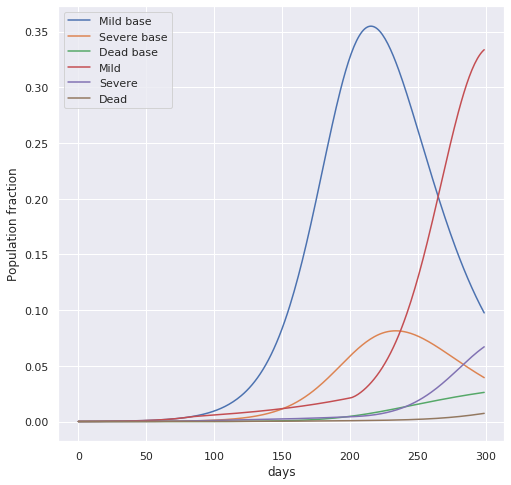

In [159]:
#num_int = 1
min_val, min_params = grid_search(num_int=1, days=300)
print(min_val)
val, states = calculate_opt(intervention_day=min_params['start_array'], intervention_duration=min_params['duration_array'],\
              intervention_choice=min_params['choice_array'], days=300)
ind = np.arange(300)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8, 8))
plt.plot(ind, states_base[2]+states_base[3], label='Mild base')
plt.plot(ind, states_base[4]+states_base[5]+states_base[6], label='Severe base')
plt.plot(ind, states_base[8], label='Dead base')
plt.plot(ind, states[2]+states[3], label='Mild')
plt.plot(ind, states[4]+states[5]+states[6], label='Severe')
plt.plot(ind, states[8], label='Dead')
plt.ylabel('Population fraction')
plt.xlabel('days')
plt.legend()
plt.show()

15147
8.39809391424677


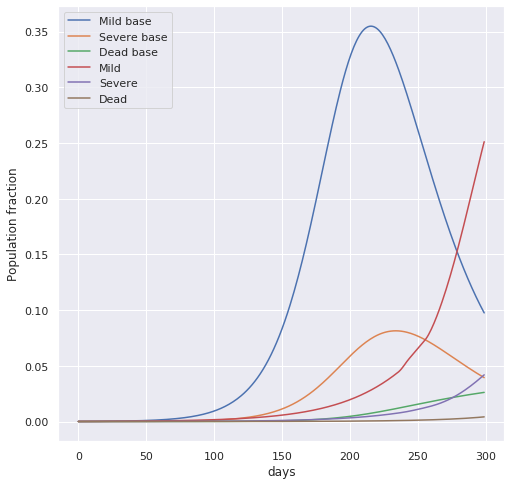

In [153]:
#num_int = 2
min_val, min_params = grid_search(num_int=2, days=300)
print(min_val)
val, states = calculate_opt(intervention_day=min_params['start_array'], intervention_duration=min_params['duration_array'],\
              intervention_choice=min_params['choice_array'], days=300)
ind = np.arange(300)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8, 8))
plt.plot(ind, states_base[2]+states_base[3], label='Mild base')
plt.plot(ind, states_base[4]+states_base[5]+states_base[6], label='Severe base')
plt.plot(ind, states_base[8], label='Dead base')
plt.plot(ind, states[2]+states[3], label='Mild')
plt.plot(ind, states[4]+states[5]+states[6], label='Severe')
plt.plot(ind, states[8], label='Dead')
plt.ylabel('Population fraction')
plt.xlabel('days')
plt.legend()
plt.show()

2454
9.217791191320595


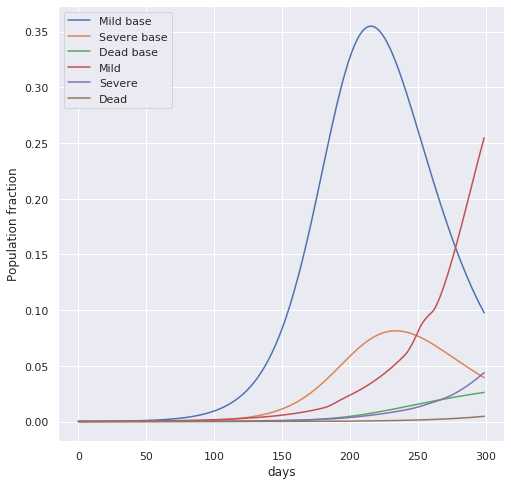

In [160]:
#num_int = 3
min_val, min_params = grid_search(num_int=3, days=300)
print(min_val)
val, states = calculate_opt(intervention_day=min_params['start_array'], intervention_duration=min_params['duration_array'],\
              intervention_choice=min_params['choice_array'], days=300)
ind = np.arange(300)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8, 8))
plt.plot(ind, states_base[2]+states_base[3], label='Mild base')
plt.plot(ind, states_base[4]+states_base[5]+states_base[6], label='Severe base')
plt.plot(ind, states_base[8], label='Dead base')
plt.plot(ind, states[2]+states[3], label='Mild')
plt.plot(ind, states[4]+states[5]+states[6], label='Severe')
plt.plot(ind, states[8], label='Dead')
plt.ylabel('Population fraction')
plt.xlabel('days')
plt.legend()
plt.show()

In [161]:
def mod_calculate_opt(variable_params, total_resource, days):
    R0 = 3 
    T_inf = 30
    T_trans = T_inf/R0
    T_inc = 5
    T_recov_mild = (50 - T_inf)
    T_hosp = 10
    T_recov_severe = (50 - T_inf)
    T_death = 50

    P_severe = 0.3
    P_fatal = 0.04
    P_mild = 1 - P_severe - P_fatal

    N = 1e6
    I0 = 100.0

    intervention_day = np.array(variable_params['intervention_day'])
    intervention_duration = np.array(variable_params['intervention_duration'])
    intervention_choice = np.array(variable_params['intervention_choice'])

    assert(len(intervention_day) == len(intervention_duration))
    assert(len(intervention_duration) == len(intervention_choice))
    if(not check(intervention_day, intervention_duration, intervention_choice, total_resource, days)):
        return(100)
    
    k = len(intervention_day)
    int_vec = np.ones(days)
    for intvn in range(k):
        for i in range(intervention_day[intvn],min(intervention_day[intvn]+intervention_duration[intvn],days)):
            int_vec[i] = get_impact(intervention_choice[intvn])
    
    params = [T_trans, T_inc, T_inf, T_recov_mild, T_hosp, T_recov_severe, T_death, 
              P_mild, P_severe, P_fatal, N, int_vec]

    # S, E, I, R_mild, R_severe, R_severe_home, R_fatal, C, D
    state_init_values = [(N - I0)/N, 0, I0/N, 0, 0, 0, 0, 0, 0]
    
    solver = SEIR(params, state_init_values)
    states_int_array = solver.solve_ode(time_step=1, total_no_of_days=days)
    
    S_coeficeint=0
    E_coeficeint=0
    I_coeficeint=0.7
    R_mild_coeficeint=0.7
    R_severe_coeficeint=0.9
    R_severe_hosp_coeficeint=0.9
    R_R_fatal_coeficeint=0.9
    C_coeficeint=0
    D_coeficeint=1
    
    
    coeficeint=[S_coeficeint,E_coeficeint,I_coeficeint,R_mild_coeficeint,R_severe_coeficeint,R_severe_hosp_coeficeint,\
                R_R_fatal_coeficeint,C_coeficeint,D_coeficeint]
    
    grad1 = np.dot(coeficeint,np.sum(states_int_array, axis=1))
        
    return(grad1)


def tpe_opt(num_int, total_resource=60, day0=10, days=500):
    min_duration = 10
    if(num_int==1):
        start_val = [start for start in range(day0, days-min_duration, 10)]
        choice_val = [0.25, 0.5, 1]
        duration_val = [duration for duration in range(10, 4*total_resource+1, 5)]

        variable_params = {
            'intervention_day' : [hp.choice('intervention_day', start_val)],
            'intervention_duration' : [hp.choice('intervention_duration', duration_val)],
            'intervention_choice' : [hp.choice('intervention_choice', choice_val)],
        }
        
    if(num_int==2):
        start_val = [start for start in range(day0, days-min_duration, 10)]
        choice_val = [0.25, 0.5, 1]
        duration_val = [duration for duration in range(10, 4*total_resource+1, 5)]

        variable_params = {
            'intervention_day' : [hp.choice('id_0', start_val),hp.choice('id_1', start_val)],
            'intervention_duration' : [hp.choice('du_0', duration_val),hp.choice('du_1', duration_val)],
            'intervention_choice' : [hp.choice('ic_0', choice_val),hp.choice('ic_1', choice_val)],
        }

    partial_calculate_opt = partial(mod_calculate_opt, total_resource=total_resource, days=days) 
    
    searchspace = variable_params
    
    trials = Trials()
    best = fmin(partial_calculate_opt,
                space=searchspace,
                algo=tpe.suggest,
                max_evals=3000,
                trials=trials)

def tpe_grid(num_int, min_params, total_resource=60, days=500):
    min_duration = 10
    window_start = 30
    if(num_int==1):
        start = int(min_params['start_array'][0] - window_start/2)
        end = int(min_params['start_array'][0] + window_start/2)
        start_val = [start for start in range(start, end)]
        choice_val = [min_params['choice_array'][0]]
        duration_val = [min_params['duration_array'][0]]

        variable_params = {
            'intervention_day' : [hp.choice('intervention_day', start_val)],
            'intervention_duration' : [hp.choice('intervention_duration', duration_val)],
            'intervention_choice' : [hp.choice('intervention_choice', choice_val)],
        }
        
    if(num_int==2):
        start = int(min_params['start_array'][0] - window_start/2)
        end = int(min_params['start_array'][0] + window_start/2)
        start_val_0 = [start for start in range(start, end)]
        start = int(min_params['start_array'][1] - window_start/2)
        end = int(min_params['start_array'][1] + window_start/2)
        start_val_1 = [start for start in range(start, end)]
        choice_val_0 = [min_params['choice_array'][0]]
        choice_val_1 = [min_params['choice_array'][1]]
        duration_val_0 = [min_params['duration_array'][0]]
        duration_val_1 = [min_params['duration_array'][1]]

        variable_params = {
            'intervention_day' : [hp.choice('id_0', start_val_0),hp.choice('id_1', start_val_1)],
            'intervention_duration' : [hp.choice('du_0', duration_val_0),hp.choice('du_1', duration_val_1)],
            'intervention_choice' : [hp.choice('ic_0', choice_val_0),hp.choice('ic_1', choice_val_1)],
        }
        
    if(num_int==3):
        start = int(min_params['start_array'][0] - window_start/2)
        end = int(min_params['start_array'][0] + window_start/2)
        start_val_0 = [start for start in range(start, end)]
        start = int(min_params['start_array'][1] - window_start/2)
        end = int(min_params['start_array'][1] + window_start/2)
        start_val_1 = [start for start in range(start, end)]
        start = int(min_params['start_array'][2] - window_start/2)
        end = int(min_params['start_array'][2] + window_start/2)
        start_val_2 = [start for start in range(start, end)]
        choice_val_0 = [min_params['choice_array'][0]]
        choice_val_1 = [min_params['choice_array'][1]]
        choice_val_2 = [min_params['choice_array'][2]]
        duration_val_0 = [min_params['duration_array'][0]]
        duration_val_1 = [min_params['duration_array'][1]]
        duration_val_2 = [min_params['duration_array'][2]]

        variable_params = {
            'intervention_day' : [hp.choice('id_0', start_val_0),hp.choice('id_1', start_val_1),hp.choice('id_2', start_val_2)],
            'intervention_duration' : [hp.choice('du_0', duration_val_0),hp.choice('du_1', duration_val_1),hp.choice('du_2', duration_val_2)],
            'intervention_choice' : [hp.choice('ic_0', choice_val_0),hp.choice('ic_1', choice_val_1),hp.choice('ic_2', choice_val_2)],
        }

    partial_calculate_opt = partial(mod_calculate_opt, total_resource=total_resource, days=days) 
    
    searchspace = variable_params
    
    trials = Trials()
    best = fmin(partial_calculate_opt,
                space=searchspace,
                algo=tpe.suggest,
                max_evals=3000,
                trials=trials)
    
    return(best, trials)

In [157]:
tpe_opt(num_int=1, days=300)

100%|██████████| 3000/3000 [00:49<00:00, 60.01trial/s, best loss: 8.314237701265618] 


In [158]:
tpe_opt(num_int=2, days=300)

100%|██████████| 3000/3000 [01:28<00:00, 33.98trial/s, best loss: 14.536810602084282]


In [152]:
tpe_grid(num_int=1, days=300, min_params=min_params)

100%|██████████| 3000/3000 [00:53<00:00, 56.05trial/s, best loss: 14.319600833168689]


({'intervention_choice': 0,
  'intervention_day': 20,
  'intervention_duration': 0},
 <hyperopt.base.Trials at 0x7efea357f6d8>)

In [154]:
tpe_grid(num_int=2, days=300, min_params=min_params)

100%|██████████| 3000/3000 [01:21<00:00, 36.63trial/s, best loss: 7.952597597932832]


({'du_0': 0, 'du_1': 0, 'ic_0': 0, 'ic_1': 0, 'id_0': 5, 'id_1': 1},
 <hyperopt.base.Trials at 0x7efea8d16358>)

In [162]:
tpe_grid(num_int=3, days=300, min_params=min_params)

100%|██████████| 3000/3000 [01:47<00:00, 27.79trial/s, best loss: 8.584438836294012]


({'du_0': 0,
  'du_1': 0,
  'du_2': 0,
  'ic_0': 0,
  'ic_1': 0,
  'ic_2': 0,
  'id_0': 5,
  'id_1': 0,
  'id_2': 0},
 <hyperopt.base.Trials at 0x7eff05bbb898>)

## Heuristic Based Method

In [116]:
# np.array([start days]), np.array([duration]), np.array([choice], number_of_days_simulated)
def run_seir(days, int_vec):
    R0 = 3 
    T_inf = 30
    T_trans = T_inf/R0
    T_inc = 5
    T_recov_mild = (50 - T_inf)
    T_hosp = 10
    T_recov_severe = (50 - T_inf)
    T_death = 50

    P_severe = 0.3
    P_fatal = 0.04
    P_mild = 1 - P_severe - P_fatal

    N = 1e6
    I0 = 100.0

    
    params = [T_trans, T_inc, T_inf, T_recov_mild, T_hosp, T_recov_severe, T_death, 
              P_mild, P_severe, P_fatal, N, int_vec]

    state_init_values = [(N - I0)/N, 0, I0/N, 0, 0, 0, 0, 0, 0]
    
    solver = SEIR(params, state_init_values)
    states_int_array = solver.solve_ode(time_step=1, total_no_of_days=days)
    
    derivatives = np.ones((days,9))
    for t in range(days):
        derivatives[t] = solver.get_derivative(t=t, y=states_int_array[:,t])
    
    S_coeficeint=0
    E_coeficeint=0
    I_coeficeint=0.7
    R_mild_coeficeint=0.7
    R_severe_coeficeint=0.9
    R_severe_hosp_coeficeint=0.9
    R_R_fatal_coeficeint=0.9
    C_coeficeint=0
    D_coeficeint=1
    
    coeficeint= np.array([S_coeficeint,E_coeficeint,I_coeficeint,R_mild_coeficeint,R_severe_coeficeint,R_severe_hosp_coeficeint,\
                          R_R_fatal_coeficeint,C_coeficeint,D_coeficeint])
    
    grad1 = np.ones(days)
    grad2 = np.ones(days)

    for i in range(days):
        grad2[i] = np.dot(coeficeint,derivatives[i])
        grad1[i] = np.dot(coeficeint,states_int_array[:,i])
    return(grad1, states_int_array)

In [117]:
total_resource = 120
resource_spent = 0
window = 5
int_vec = np.ones(500)
while(resource_spent<total_resource):
    curve, states = run_seir(days=500, int_vec=int_vec)
    arg_curve = (-curve).argsort()
    day_max = arg_curve[0]
    i=1
    while(int_vec[day_max]>=3):
        day_max = arg_curve[i]
        i += 1

    int_vec[day_max] += 0.25 
    resource_spent += 0.25

In [118]:
int_vec

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 1., 1., 1., 1.

In [119]:
curve, states = run_seir(days=500, int_vec=int_vec)
print(np.sum(curve))
curve_base, states_base = run_seir(days = 500, int_vec=np.ones(500))
np.sum(curve_base)

41.642376391181955


46.31844218274206

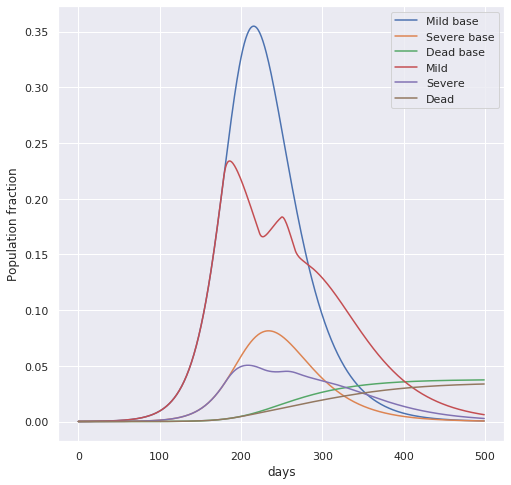

In [120]:
ind = np.arange(500)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8, 8))
plt.plot(ind, states_base[2]+states_base[3], label='Mild base')
plt.plot(ind, states_base[4]+states_base[5]+states_base[6], label='Severe base')
plt.plot(ind, states_base[8], label='Dead base')
plt.plot(ind, states[2]+states[3], label='Mild')
plt.plot(ind, states[4]+states[5]+states[6], label='Severe')
plt.plot(ind, states[8], label='Dead')
plt.ylabel('Population fraction')
plt.xlabel('days')
plt.legend()
plt.show()

## Smart Heuristic Method

In [121]:
def get_overlap(ps,pe,s,e):
    if(s>pe or e<ps):
        return(0)
    else:
        max_s = max(ps,s)
        min_e = min(pe,e)
        return(min_e - max_s + 1)
    
def get_dist(tup1, tup2):
    return(abs(sum(tup1)-sum(tup2)))

def shift(ps,pe,s,e):
    if(ps+pe > s+e):
        return(e+1,pe+e-ps+1)
    else:
        return(ps+s-pe-1,s-1)

def check_overlap(p_time, int_list):
    if(not len(int_list)):
        return(p_time)
    elif(len(int_list)<5 and len(int_list)>=1):
        (ps, pe) = p_time
        max_overlap = 0
        mo_s, mo_e = 0, 0
        for i in range(len(int_list)):
            s, e = int_list[i]
            overlap = get_overlap(ps,pe,s,e)
            if(overlap>5):
                return((s,e))
            if(overlap>max_overlap):
                max_overlap = overlap
                mo_s, mo_e = s, e
                
        if(max_overlap==0):
            return((ps,pe))
        else:
            ns, ne = shift(ps,pe,mo_s,mo_e)
            if(ns<30):
                return((mo_s,mo_e))
            for i in range(len(int_list)):
                s, e = int_list[i]
                overlap = get_overlap(ns,ne,s,e)
                if(overlap>0):
                    return((mo_s,mo_e))
            return((ns,ne))
        
    else:
        min_dist = 500
        min_dist_s = 0
        min_dist_e = 0
        for i in range(len(int_list)):
            dist = get_dist(p_time, int_list[i])
            if(dist<min_dist):
                min_dist_s, min_dist_e = int_list[i]
        return((min_dist_s,min_dist_e))

In [122]:
total_resource = 120
resource_spent = 0
min_d = 10
init_day = 10
max_num_int = 5
int_vec = np.ones(500)
interventions = []
while(resource_spent<total_resource):
    curve, states = run_seir(days=500, int_vec=int_vec)
    arg_curve = (-curve).argsort()
    day_max = arg_curve[0]
    i=1
    while(day_max<init_day or int_vec[day_max]>=2):
        day_max = arg_curve[i]
        i += 1

    buffer = day_max - init_day
    if(buffer<min_d/2):
        (start,end) = check_overlap((init_day, init_day+min_d),interventions)
    else:
        (start,end) = check_overlap((day_max-min_d/2+1, day_max+min_d/2),interventions)
        
    start, end = int(start), int(end)
    
    if(int_vec[start]==1):
        int_vec[start:end+1] = 1.5
        resource_spent += 2.5
    elif(int_vec[start]==1.5):
        int_vec[start:end+1] = 2
        resource_spent += 2.5
    else:
        int_vec[start:end+1] = 3
        resource_spent += 5 
    if((start,end) not in interventions):
        interventions.append((start,end))

In [123]:
int_vec

array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1.

In [124]:
curve, states = run_seir(days=500, int_vec=int_vec)
print(np.sum(curve))
curve_base, states_base = run_seir(days = 500, int_vec=np.ones(500))
np.sum(curve_base)

44.54663090711294


46.31844218274206

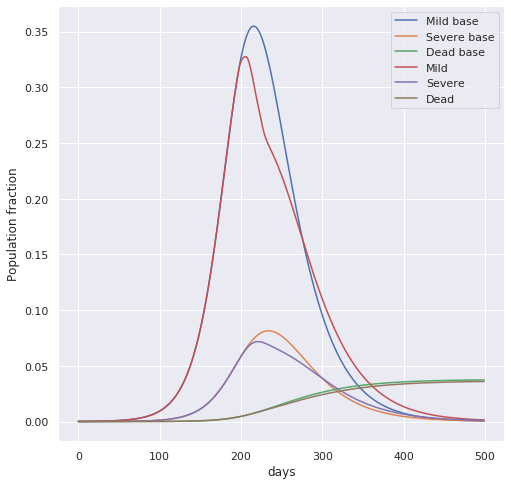

In [125]:
ind = np.arange(500)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8, 8))
plt.plot(ind, states_base[2]+states_base[3], label='Mild base')
plt.plot(ind, states_base[4]+states_base[5]+states_base[6], label='Severe base')
plt.plot(ind, states_base[8], label='Dead base')
plt.plot(ind, states[2]+states[3], label='Mild')
plt.plot(ind, states[4]+states[5]+states[6], label='Severe')
plt.plot(ind, states[8], label='Dead')
plt.ylabel('Population fraction')
plt.xlabel('days')
plt.legend()
plt.show()

## Gradient Based Methods

In [126]:
def run_seir_grad(days, int_vec):
    R0 = 3 
    T_inf = 30
    T_trans = T_inf/R0
    T_inc = 5
    T_recov_mild = (50 - T_inf)
    T_hosp = 10
    T_recov_severe = (50 - T_inf)
    T_death = 50

    P_severe = 0.3
    P_fatal = 0.04
    P_mild = 1 - P_severe - P_fatal

    N = 1e6
    I0 = 100.0

    
    params = [T_trans, T_inc, T_inf, T_recov_mild, T_hosp, T_recov_severe, T_death, 
              P_mild, P_severe, P_fatal, N, int_vec]

    state_init_values = [(N - I0)/N, 0, I0/N, 0, 0, 0, 0, 0, 0]
    
    solver = SEIR(params, state_init_values)
    states_int_array = solver.solve_ode(time_step=1, total_no_of_days=days)
    
    derivatives = np.ones((days,9))
    for t in range(days):
        derivatives[t] = solver.get_derivative(t=t, y=states_int_array[:,t])
    
    S_coeficeint=0
    E_coeficeint=0
    I_coeficeint=0.7
    R_mild_coeficeint=0.7
    R_severe_coeficeint=0.9
    R_severe_hosp_coeficeint=0.9
    R_R_fatal_coeficeint=0.9
    C_coeficeint=0
    D_coeficeint=1
    
    coeficeint= np.array([S_coeficeint,E_coeficeint,I_coeficeint,R_mild_coeficeint,R_severe_coeficeint,R_severe_hosp_coeficeint,\
                          R_R_fatal_coeficeint,C_coeficeint,D_coeficeint])
    
    grad1 = np.ones(days)
    grad2 = np.ones(days)

    for i in range(days):
        grad2[i] = np.dot(coeficeint,derivatives[i])
        grad1[i] = np.dot(coeficeint,states_int_array[:,i])
    return(grad1)

In [127]:
def get_grad(int_vec):
    days = len(int_vec)
    num_pts = 3  # number of points used for derievative.
    grad_vec = np.ones(days)
    for i in range(10, days):
    #     i represents the ith dimension of T_transi
        val = int_vec[i]
        window_size = 0.005
        values = np.random.uniform(val-window_size, val+window_size, num_pts)
        f_values = np.ones_like(values)
        for j,value in enumerate(values):
            int_vec[i] = value
            f_values[j] = np.sum(run_seir_grad(days, int_vec))
        values = np.append(values,val)
        int_vec[i] = val
        fval = np.sum(run_seir_grad(days, int_vec))
        f_values = np.append(f_values,fval)
        derivative = np.gradient(f_values, values, edge_order=2)
        grad_vec[i] = derivative[-1]
    return(grad_vec)

In [128]:
from pulp import *
def opt_step(grad):
    prob = LpProblem("Minimization over constrained space",LpMinimize)

    day_list = list((np.arange(500-10)).astype(str))

    int_days = LpVariable.dicts("day",day_list,lowBound=1,upBound=3,cat='Continuous')

#     grad = get_grad(np.ones(400))

    prob += lpSum([grad[int(i)]*int_days[i] for i in day_list]) #objective function
    prob += lpSum([int_days[f] for f in day_list]) <= 620.0-10.0 #TotalResource
    prob.solve()
    opt_val = np.ones(500)
    for v in prob.variables():
        idx = v.name.split('_')[-1]
        opt_val[int(idx)+10] = v.varValue
        
    return(opt_val)

In [129]:
num_iter = 100
best_val = 50
int_vec = np.ones(500)
best_int_vec = np.ones(500)
for i in range(num_iter):
    gradient = get_grad(int_vec)
    opt = opt_step(gradient)
    gamma = 2.0/(3+i)
    int_vec = int_vec + gamma*(opt-int_vec)
    value = np.sum(run_seir_grad(int_vec=int_vec,days=500))
    print(value)
    if(value < best_val):
        best_val = value
        best_int_vec = int_vec
print(best_val)

/home/users/bhardwaj/env_covid/lib/python3.7/site-packages/pulp/pulp.py:1114: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


42.22911658884687
40.95847023878893
40.19741134626172
40.049161404516504
39.34294398501897
39.377376928953154
39.45533684228122
39.44760813559649
39.547879148918106
39.62526489756401
39.73987541614896
39.89795628000118
40.016557572374
40.08927423001121
40.12226821083464
40.147505436748915
40.165619452557124
40.1803383357091
40.24505870326492
40.31299627280998
40.35170276942961
40.377338394401946
40.411832733302916
40.45253818610145
40.48842585007738
40.51619731411931
40.528155026869754
40.54386603531107
40.56330191861667
40.571471766572316
40.58147638075461
40.59588901565188
40.614332388782714
40.64026718453364
40.65864020544501
40.676463163538806
40.69362672271956
40.7110739910957
40.7262511171078
40.739982434766205
40.75879721370602
40.78116820843235
40.80006474617997
40.81331938131362
40.82098216754479
40.823307955296826
40.8242229734126
40.8307970466994
40.822360175635104
40.81087384176928
40.79889430164795
40.7939627858416
40.7944205343105
40.791048401951706
40.79247771624425
40.7

39.34294398501897


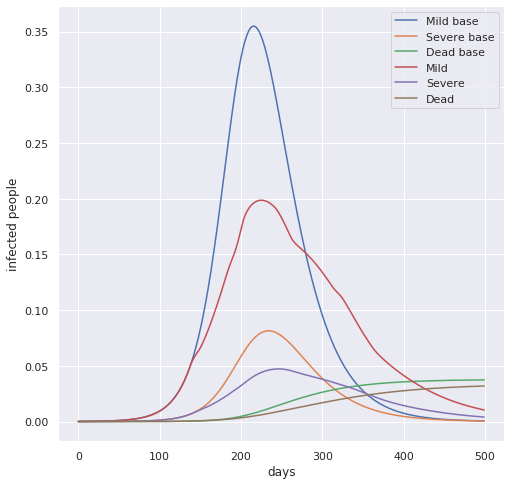

In [140]:
print(best_val)
curve, states = run_seir(days=500, int_vec=best_int_vec)
ind = np.arange(500)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8, 8))
plt.plot(ind, states_base[2]+states_base[3], label='Mild base')
plt.plot(ind, states_base[4]+states_base[5]+states_base[6], label='Severe base')
plt.plot(ind, states_base[8], label='Dead base')
plt.plot(ind, states[2]+states[3], label='Mild')
plt.plot(ind, states[4]+states[5]+states[6], label='Severe')
plt.plot(ind, states[8], label='Dead')
plt.ylabel('infected people')
plt.xlabel('days')
plt.legend()
plt.show()

In [132]:
int_vec = best_int_vec.copy()
int_vec[int_vec<1.25]=1
int_vec[np.logical_and(int_vec<1.75, int_vec>1.25)] = 1.5
int_vec[int_vec>1.75] = 2